In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import numpy as np
import torch

print("NumPy version:", np.__version__)
print("PyTorch version:", torch.__version__)

NumPy version: 1.26.3
PyTorch version: 2.5.1+cu118


In [3]:
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get the device name
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


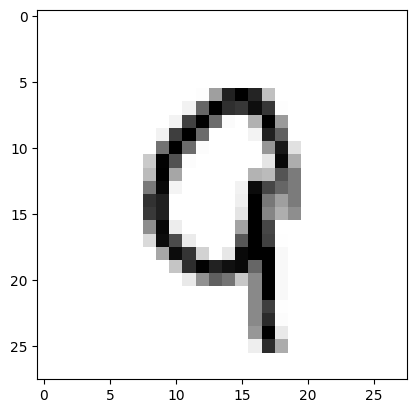

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.show()

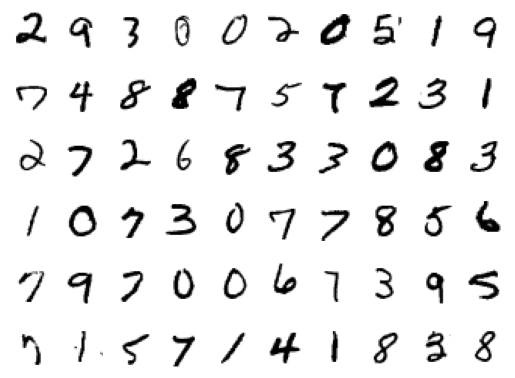

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
plt.show();

In [12]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 28>28 | 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 28 > 28 |  5
        self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 14> 14 | 12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #14 > 14 | 14
        self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 28
        self.conv5 = nn.Conv2d(256, 512, 3) # 7 > 5 | 30
        self.conv6 = nn.Conv2d(512, 1024, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 | 
        self.conv7 = nn.Conv2d(1024, 10, 3) # 3 > 1 | 34 | > 1x1x10

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

In [14]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
--------------------------------

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07023395597934723 Batch_id=468 Accuracy=88.93: 100%|██████████| 469/469 [00:25<00:00, 18.67it/s] 



Test set: Average loss: 0.0494, Accuracy: 9851/10000 (98.51%)

EPOCH: 1


Loss=0.04711303487420082 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]  



Test set: Average loss: 0.0387, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.04887145385146141 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]  



Test set: Average loss: 0.0315, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.008143682964146137 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s] 



Test set: Average loss: 0.0341, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.09215808659791946 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:24<00:00, 18.76it/s]   



Test set: Average loss: 0.0376, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.00526953861117363 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]   



Test set: Average loss: 0.0341, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.017436733469367027 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:24<00:00, 19.27it/s]  



Test set: Average loss: 0.0309, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.006771245505660772 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]  



Test set: Average loss: 0.0259, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.0024215606972575188 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:24<00:00, 18.90it/s] 



Test set: Average loss: 0.0288, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.016790715977549553 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]  



Test set: Average loss: 0.0304, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.029710538685321808 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]  



Test set: Average loss: 0.0281, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Loss=0.0005118827684782445 Batch_id=468 Accuracy=99.90: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s] 



Test set: Average loss: 0.0280, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=6.101322651375085e-05 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s] 



Test set: Average loss: 0.0303, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.007976213470101357 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]  



Test set: Average loss: 0.0348, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.0025547349359840155 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s] 



Test set: Average loss: 0.0325, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=1.3769406905339565e-05 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]



Test set: Average loss: 0.0320, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=1.1298630852252245e-05 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s] 



Test set: Average loss: 0.0324, Accuracy: 9922/10000 (99.22%)

EPOCH: 17


Loss=0.00016290508210659027 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:25<00:00, 18.40it/s] 



Test set: Average loss: 0.0346, Accuracy: 9918/10000 (99.18%)

EPOCH: 18


Loss=0.00034467573277652264 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]



Test set: Average loss: 0.0394, Accuracy: 9917/10000 (99.17%)

EPOCH: 19


Loss=0.00013100482465233654 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]



Test set: Average loss: 0.0383, Accuracy: 9918/10000 (99.18%)



In [19]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

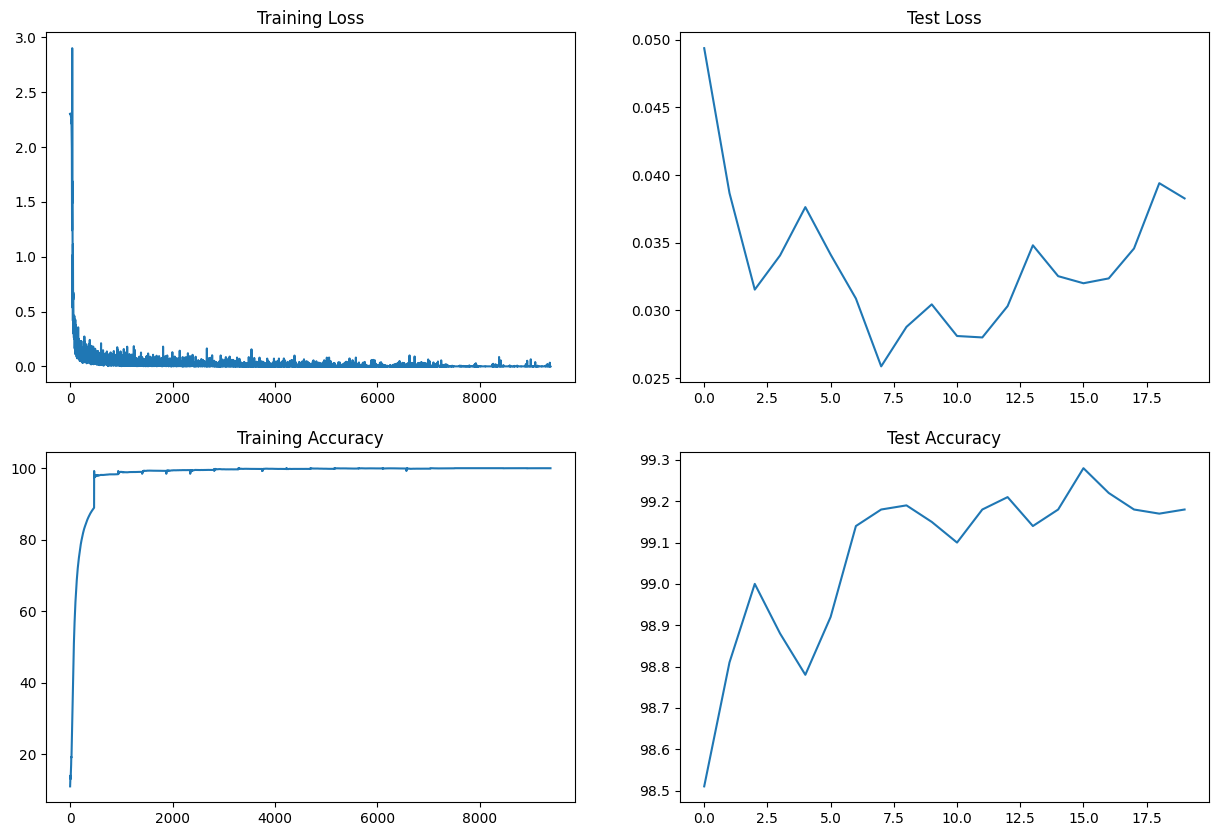

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")